In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
# Create an empty array to store pokemon pics
orig_img = np.empty((0, 40, 40, 4), dtype='float32')
# Load all images and append into orig_img
path = os.path.abspath("./VAE.ipynb")
path = re.sub('[a-zA-Z\s.]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    orig_img = np.append(orig_img, [mpimg.imread(pic)], axis=0)

# Flat all data to one dimension
X_flat = np.empty((0, 6400), dtype='float32')
for i in xrange(orig_img.shape[0]):
    X_flat = np.append(X_flat, [orig_img[i].reshape(6400)], axis=0)

In [9]:
# Parameters
learning_rate = 0.01
training_epochs = 100
batch_size = 79
display_step = 5
examples_to_show = 6

# Network Parameters
n_hidden_1 = 1024 
n_hidden_2 = 256 
n_input = 6400 # Pokemon input (img shape: 40*40*4)

In [7]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input]))
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input]))
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                  biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

In [8]:
# Construct model
encoder_op = encoder(X_flat)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X_flat

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [10]:
sess = tf.InteractiveSession()
sess.run(init)
total_batch = int(X_flat.shape[0]/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    start = 0; end = batch_size-1
    for i in range(total_batch):
        index = np.arange(start, end)
        np.random.shuffle(index)
        batch_xs = X_flat[index]
        start = end+1; end = start+batch_size-1
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if epoch % display_step == 0:
        print 'Epoch: {0:04d}   cost: {1:f}'.format(epoch, c)

print("Optimization Finished!")

Epoch: 0000   cost: 0.458670
Epoch: 0005   cost: 0.458267
Epoch: 0010   cost: 0.453222
Epoch: 0015   cost: 0.399465
Epoch: 0020   cost: 0.328835
Epoch: 0025   cost: 0.311254
Epoch: 0030   cost: 0.296084
Epoch: 0035   cost: 0.290138
Epoch: 0040   cost: 0.286970
Epoch: 0045   cost: 0.284414
Epoch: 0050   cost: 0.282632
Epoch: 0055   cost: 0.281339
Epoch: 0060   cost: 0.279574
Epoch: 0065   cost: 0.277955
Epoch: 0070   cost: 0.277303
Epoch: 0075   cost: 0.276097
Epoch: 0080   cost: 0.275540
Epoch: 0085   cost: 0.274282
Epoch: 0090   cost: 0.273640
Epoch: 0095   cost: 0.272698
Optimization Finished!


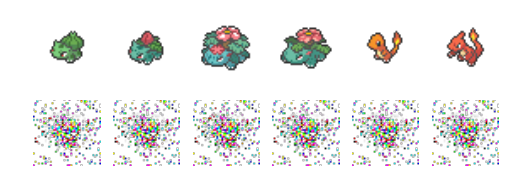

In [12]:
index = np.random.randint(X_flat.shape[0], size=examples_to_show)
autoencoder = sess.run(
    y_pred, feed_dict={X: X_flat[index]})
# Compare original images with their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(X_flat[i], (40, 40, 4)))
    a[0,i].axis('off')
    a[1][i].imshow(np.reshape(autoencoder[i], (40, 40, 4)))
    a[1,i].axis('off')
f.show()
plt.draw()

In [ ]:
if(False):
    index_in_epoch=0, epochs_completed=0
    def next_batch(data, batch_size):
        """Return the next `batch_size` examples from this data set."""
        num_examples = data.shape[0]
        start = index_in_epoch
        index_in_epoch += batch_size
        if index_in_epoch > num_examples:
            # Finished epoch
            epochs_completed += 1
            # Shuffle the data
            perm = np.arange(num_examples)
            np.random.shuffle(perm)
            images = data[perm]
            # Start next epoch
            start = 0
            index_in_epoch = batch_size
            assert batch_size <= num_examples
        end = index_in_epoch
        return data[start:end]